In [2]:
# import npz 
import numpy as np
import torch

left_kpt_2d_path = "/workspace/data/pt/run_3/osmo_1.pt"
left_kpt_3d_path = "/workspace/code/logs/pose3d/2025-10-23/07-51-43/run_3/videopose3d/left/osmo_1.npy"

left_data = torch.load(left_kpt_2d_path)
left_kpt_2d = left_data['detectron2']['keypoints']
left_kpt_3d = np.load(left_kpt_3d_path)

W, H = left_data['img_shape']

In [3]:
right_kpt_2d_path = "/workspace/data/pt/run_3/osmo_2.pt"
right_kpt_3d_path = "/workspace/code/logs/pose3d/2025-10-23/07-51-43/run_3/videopose3d/right/osmo_2.npy"

right_data = torch.load(right_kpt_2d_path)
right_kpt_2d = right_data['detectron2']['keypoints']
right_kpt_3d = np.load(right_kpt_3d_path)


In [4]:
import numpy as np
import torch

orientation = np.array(
    [0.1407056450843811,
        -0.1500701755285263,
        -0.755240797996521,
        0.6223280429840088,
    ],    dtype=np.float32,
)
def wrap(func, *args, unsqueeze=False):
    args = list(args)
    for i, arg in enumerate(args):
        if isinstance(arg, np.ndarray):
            args[i] = torch.from_numpy(arg)
            if unsqueeze:
                args[i] = args[i].unsqueeze(0)
    result = func(*args)
    if isinstance(result, torch.Tensor):
        if unsqueeze:
            result = result.squeeze(0)
        return result.numpy()
    return result

def qrot(q, v):
    assert q.shape[-1] == 4 and v.shape[-1] == 3
    qvec = q[..., 1:]
    uv = torch.cross(qvec, v, dim=len(q.shape)-1)
    uuv = torch.cross(qvec, uv, dim=len(q.shape)-1)
    return v + 2 * (q[..., :1] * uv + uuv)

def camera_to_world(X, R, t):
    q_full = np.tile(R, (*X.shape[:-1], 1))
    return wrap(qrot, q_full, X) + t


predictions = camera_to_world(left_kpt_3d, R=orientation, t=0)
# We don't have the trajectory, but at least we can rebase the height
predictions[:, :, 2] -= np.min(predictions[:, :, 2])
print(predictions.shape)  # (17, 3)


(360, 17, 3)


In [5]:
predictions[0][0]

array([-4.172739e-06, -9.464802e-06,  6.777117e-01], dtype=float32)

Frame 0:


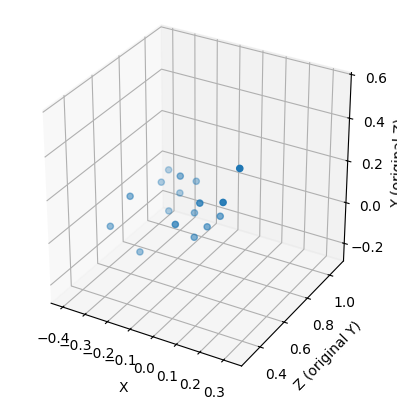

Frame 1:


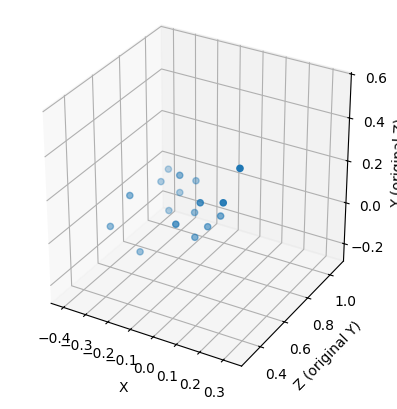

Frame 2:


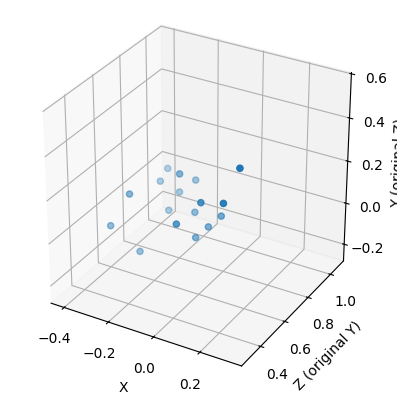

Frame 3:


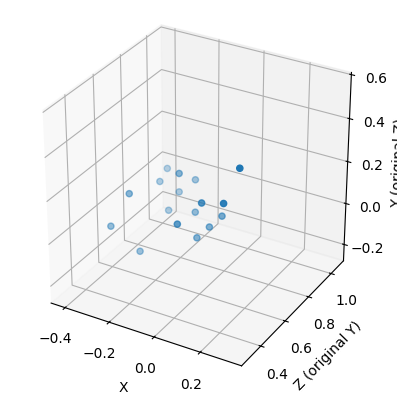

Frame 4:


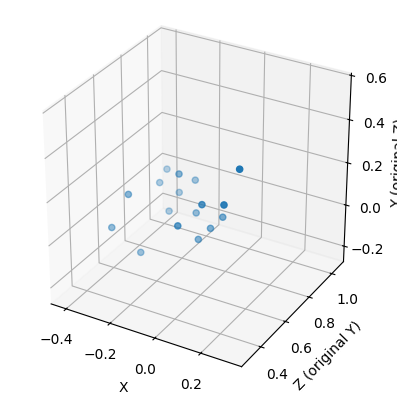

Frame 5:


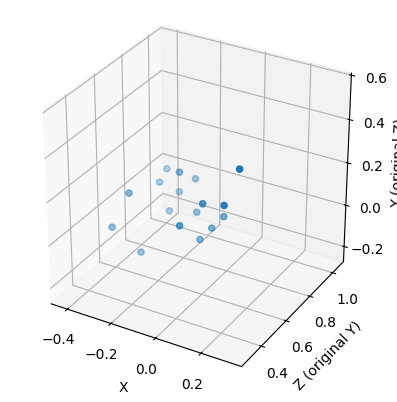

Frame 6:


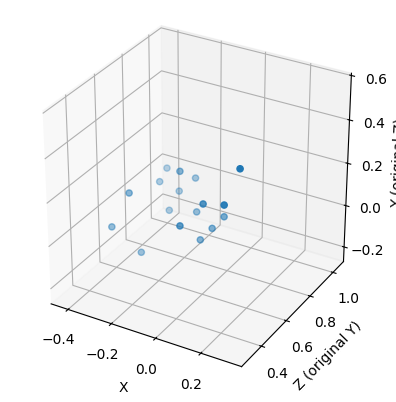

Frame 7:


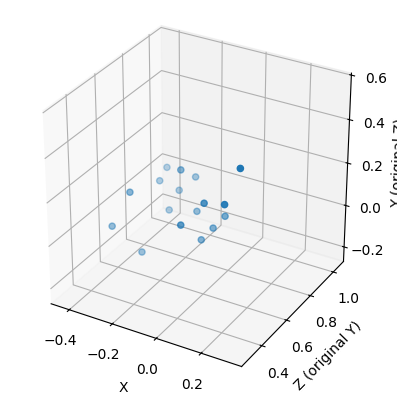

Frame 8:


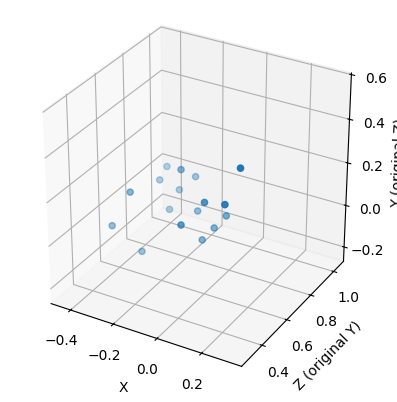

Frame 9:


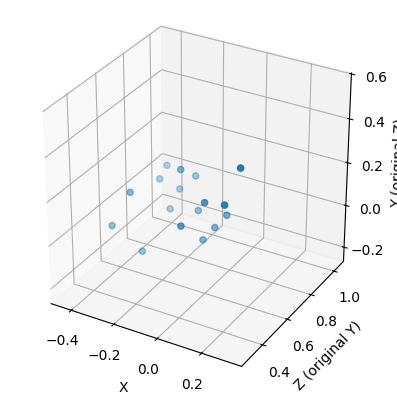

Frame 10:


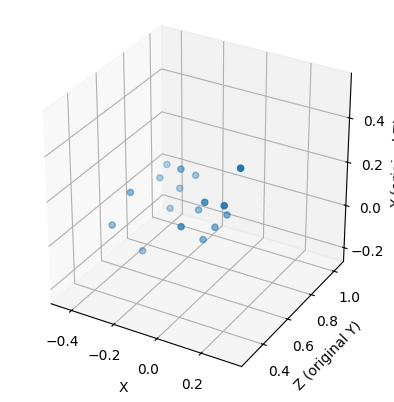

Frame 11:


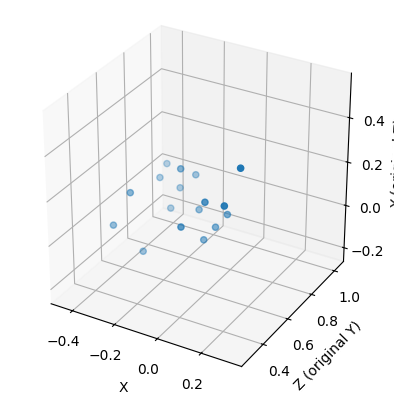

In [6]:
import matplotlib.pyplot as plt

for i in range(len(predictions)):
    print(f"Frame {i}:")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = predictions[i][:, 0]
    y = predictions[i][:, 2]   # ✅ 原来的 z 改成 y
    z = predictions[i][:, 1]   # ✅ 原来的 y 改成 z

    ax.scatter(x, y, z)
    ax.set_xlabel('X')
    ax.set_ylabel('Z (original Y)')
    ax.set_zlabel('Y (original Z)')

    # 可选：保持视觉比例一致
    ax.set_box_aspect([1,1,1])

    plt.show()

    if i > 10:
        break


In [7]:
import numpy as np

# ---- COCO-17 关节顺序 ----
# 0 nose, 1 l_eye, 2 r_eye, 3 l_ear, 4 r_ear,
# 5 l_shoulder, 6 r_shoulder, 7 l_elbow, 8 r_elbow,
# 9 l_wrist, 10 r_wrist, 11 l_hip, 12 r_hip,
# 13 l_knee, 14 r_knee, 15 l_ankle, 16 r_ankle

L_SHO, R_SHO, L_HIP, R_HIP = 5, 6, 11, 12

def coco_pelvis(points):
    """髋部中点作为 pelvis (3,)"""
    return (points[L_HIP] + points[R_HIP]) * 0.5

def coco_neck(points):
    """肩部中点作为 neck (3,)"""
    return (points[L_SHO] + points[R_SHO]) * 0.5

def center_scale_coco(X):
    """
    以 pelvis(髋中点) 为原点，按 pelvis–neck 距离做尺度归一（身高≈1）
    X: (17,3) numpy
    return: Xn(17,3), scale(float)
    """
    X = X.copy()
    pelvis = coco_pelvis(X)
    neck   = coco_neck(X)
    X -= pelvis
    s = np.linalg.norm(neck - pelvis)
    if s > 1e-8:
        X /= s
    else:
        s = 1.0
    return X, s

def umeyama(X, Y, allow_scale=True):
    """求 s,R,t 使 s*R*Y + t ≈ X（X,Y: Nx3）"""
    X, Y = np.asarray(X), np.asarray(Y)
    muX, muY = X.mean(0), Y.mean(0)
    Xc, Yc = X - muX, Y - muY
    Sigma = Yc.T @ Xc / len(X)
    U, S, Vt = np.linalg.svd(Sigma)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
    if allow_scale:
        varY = (Yc**2).sum() / len(Y)
        s = (S.sum()) / (varY + 1e-9)
    else:
        s = 1.0
    t = muX - s * (R @ muY)
    return s, R, t

def fuse_two(L, R_aligned, tau=0.06, wL=None, wR=None):
    """逐关节融合；L/R_aligned: (17,3)"""
    J = L.shape[0]
    if wL is None: wL = np.ones(J)
    if wR is None: wR = np.ones(J)
    out = np.empty_like(L)
    for j in range(J):
        Lj, Rj = L[j], R_aligned[j]
        if not (np.all(np.isfinite(Lj)) and np.all(np.isfinite(Rj))):
            out[j] = Lj if np.all(np.isfinite(Lj)) else Rj
            continue
        if np.linalg.norm(Lj - Rj) > tau:
            out[j] = Lj if wL[j] >= wR[j] else Rj
        else:
            out[j] = (wL[j]*Lj + wR[j]*Rj) / (wL[j]+wR[j] + 1e-9)
    return out

def fuse_pose_no_extrinsics_coco(left_3d, right_3d, tau=0.06, allow_scale=True):
    """
    left_3d, right_3d: (17,3) COCO-17 单帧
    输出：融合后的 (17,3)，坐标为“以髋中点为原点、pelvis–neck≈1”的归一化系
    """
    # 1) 规范化
    L, _ = center_scale_coco(left_3d)
    R, _ = center_scale_coco(right_3d)

    # 2) 仅用“躯干”点估计相似变换：pelvis_mid、neck_mid、l/r hip、l/r shoulder
    torso_L = np.vstack([coco_pelvis(L), coco_neck(L), L[L_HIP], L[R_HIP], L[L_SHO], L[R_SHO]])
    torso_R = np.vstack([coco_pelvis(R), coco_neck(R), R[L_HIP], R[R_HIP], R[L_SHO], R[R_SHO]])
    s, Rm, t = umeyama(torso_L, torso_R, allow_scale=allow_scale)

    # 3) 对齐右侧并融合
    R_aligned = (s * (Rm @ R.T).T + t)
    fused = fuse_two(L, R_aligned, tau=tau)
    return fused

# left_3d, right_3d: (J,3) 的 numpy 数组（同一帧）
fused = fuse_pose_no_extrinsics_coco(left_kpt_3d[0], right_kpt_3d[0], tau=0.06)
print(fused)  # 融合后的3D关键点坐标


[[-0.27215093  0.23041193 -0.35332403]
 [-0.30023792  0.23380515 -0.45326045]
 [-0.25336504  0.58842874 -0.65009564]
 [-0.37974402  0.83624053 -1.0780004 ]
 [-0.24407116  0.22714105 -0.25338605]
 [-0.20306686  0.5722662  -0.45564297]
 [-0.3941205   0.8120628  -0.858511  ]
 [-0.13617095  0.0345643  -0.2623564 ]
 [ 0.03791217 -0.19894838 -0.17399012]
 [ 0.1458817  -0.16353294 -0.18123695]
 [ 0.18236439 -0.3103453  -0.18787536]
 [ 0.02475406 -0.1418176  -0.07347223]
 [-0.02475406  0.1418176   0.07347227]
 [ 0.15192953  0.25778192 -0.01918135]
 [-0.01270987 -0.1597146  -0.31689656]
 [ 0.00822123  0.12285883 -0.44572768]
 [ 0.14387813  0.2592575  -0.24469234]]


In [8]:
all_fused = []
for f in range(left_kpt_3d.shape[0]):
    fused = fuse_pose_no_extrinsics_coco(left_kpt_3d[f], right_kpt_3d[f], tau=0.06)
    all_fused.append(fused)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import io

# ===== COCO-17 骨架连接定义 =====
# COCO-17 骨架（左/右臂、腿、躯干、头部）
COCO_SKELETON = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (5, 7),
    (7, 9),
    (6, 8),
    (8, 10),
    (5, 6),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16),
]

def set_equal_aspect_3d(ax, X, Y, Z):
    xs, ys, zs = np.array(X), np.array(Y), np.array(Z)
    max_range = np.array([xs.max()-xs.min(), ys.max()-ys.min(), zs.max()-zs.min()]).max()
    mid_x = (xs.max()+xs.min())/2
    mid_y = (ys.max()+ys.min())/2
    mid_z = (zs.max()+zs.min())/2
    r = max_range/2 * 1.05
    ax.set_xlim(mid_x-r, mid_x+r)
    ax.set_ylim(mid_y-r, mid_y+r)
    ax.set_zlim(mid_z-r, mid_z+r)

def plot_coco3d_frame(points, swap_yz=True, show_labels=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = points[:, 0]
    y = points[:, 2] if swap_yz else points[:, 1]
    z = points[:, 1] if swap_yz else points[:, 2]

    # 绘制散点
    ax.scatter(x, y, z, s=20, color='k')

    # 添加编号 label
    if show_labels:
        for idx, (xi, yi, zi) in enumerate(zip(x, y, z)):
            ax.text(xi, yi, zi, f"{idx}", fontsize=8, color='red')

    # 绘制连线
    for (a,b) in COCO_SKELETON:
        ax.plot([x[a],x[b]], [y[a],y[b]], [z[a],z[b]], c='blue', lw=2)

    ax.set_xlabel('X')
    ax.set_ylabel('Z' if swap_yz else 'Y')
    ax.set_zlabel('Y' if swap_yz else 'Z')
    set_equal_aspect_3d(ax, x, y, z)
    # ax.view_init(elev=20, azim=-75)
    ax.view_init(elev=20, azim=+90)

    plt.tight_layout()
    return fig

def save_coco3d_gif(all_fused, gif_path="fused_pose.gif", swap_yz=True, fps=10):
    frames = []
    for i, f in enumerate(all_fused):
        fig = plot_coco3d_frame(f, swap_yz=swap_yz, show_labels=True)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        frames.append(imageio.v2.imread(buf))
        buf.close()
        print(f"Rendered frame {i+1}/{len(all_fused)}")
    imageio.mimsave(gif_path, frames, fps=fps)
    print(f"✅ GIF saved to {gif_path}")

# ===== 示例 =====
save_coco3d_gif(all_fused, "fused_pose.gif", fps=10, swap_yz=True)


Rendered frame 1/360
Rendered frame 2/360
Rendered frame 3/360
Rendered frame 4/360
Rendered frame 5/360
Rendered frame 6/360
Rendered frame 7/360
Rendered frame 8/360
Rendered frame 9/360
Rendered frame 10/360
Rendered frame 11/360
Rendered frame 12/360
Rendered frame 13/360
Rendered frame 14/360
Rendered frame 15/360
Rendered frame 16/360
Rendered frame 17/360
Rendered frame 18/360
Rendered frame 19/360
Rendered frame 20/360
Rendered frame 21/360
Rendered frame 22/360
Rendered frame 23/360
Rendered frame 24/360
Rendered frame 25/360
Rendered frame 26/360
Rendered frame 27/360
Rendered frame 28/360
Rendered frame 29/360
Rendered frame 30/360
Rendered frame 31/360
Rendered frame 32/360
Rendered frame 33/360
Rendered frame 34/360
Rendered frame 35/360
Rendered frame 36/360
Rendered frame 37/360
Rendered frame 38/360
Rendered frame 39/360
Rendered frame 40/360
Rendered frame 41/360
Rendered frame 42/360
Rendered frame 43/360
Rendered frame 44/360
Rendered frame 45/360
Rendered frame 46/3